# Rayleigh drag
Display closeup of Rayleigh drag (if any).

Based on `/home/156/aek156/notebooks/github/aekiss/notebooks/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb`
https://github.com/aekiss/notebooks/blob/master/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb

and
https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/Rayleigh_drag/Rayleigh_drag.ipynb

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import os

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=200, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=200, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
path = '/g/data/ik11/inputs/access-om2/input_rc/mom_1deg/'
path = '/scratch/v45/aek156/access-om2/archive/1deg_jra55_ryf_v2.0.0rc7/output000/ocean/'
ftfile = path + 'field_table'
# gridfile = xr.open_dataset(path + 'ocean_hgrid.nc')
# gridfile = xr.open_dataset(path + 'ocean_grid.nc')
# geolon_c = geolon_c.x
# geolat_c = geolat_c.y
# kmu = gridfile.kmu
# hu = gridfile.hu  # hu has correct u-cell mask (kmu uses t-cell mask)

geolon_c = xr.open_dataset(path + 'ocean-2d-geolon_c.nc').geolon_c
geolat_c = xr.open_dataset(path + 'ocean-2d-geolat_c.nc').geolat_c
kmu = xr.open_dataset(path + 'ocean-2d-kmu.nc').kmu
hu = xr.open_dataset(path + 'ocean-2d-hu.nc').hu  # hu has correct u-cell mask (kmu uses t-cell mask)

damp_table = ''
with open(ftfile,"r") as f:
    for line in f:
        if line.startswith('"rayleigh_damp_table"'):
            break
    for line in f:
        if line.startswith('"rayleigh"'):
            damp_table += line
        else:
            break

damp_table_ii = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]  # subtract 1 to index from 0
damp_table_jj = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]  # subtract 1 to index from 0
damp_time = [ int(j) for j in re.findall('rayleigh_damp_table=(\d+)', damp_table) ]
ktable_1 = [ int(j) for j in re.findall('ktable_1=(\d+)', damp_table) ]
ktable_2 = [ int(j) for j in re.findall('ktable_2=(\d+)', damp_table) ]

# make damp time map; use kmu to get land mask
dtm = hu.where(np.isnan(hu), 0)  # zero out ocean points
for i, j, dt in zip(damp_table_ii, damp_table_jj, damp_time):
    if not np.isnan(dtm[j][i]):
        dtm[j][i] = dt  # put damp_time value in at every ocean point that has damping
damp_time_map = dtm

# make map of number of non-damped cells in each damped column
undamped = hu.where(np.isnan(hu), 0)  # zero out ocean points
for i, j, kt1, kt2 in zip(damp_table_ii, damp_table_jj, ktable_1, ktable_2):
    if not np.isnan(undamped[j][i]):
        undamped[j][i] = max(0, kmu[j][i] - kt2) + kt1 - 1

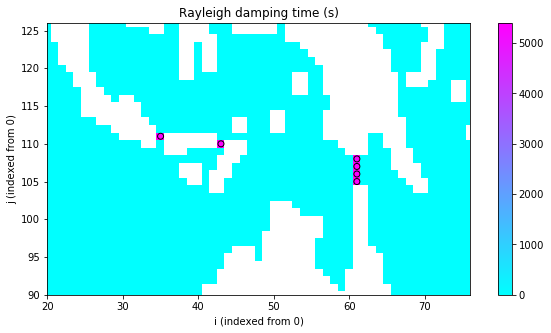

In [4]:
# damping rate plots
margin = 15  # grid cells
if len(damp_time) > 0:
    imin = min(damp_table_ii) - margin
    imax = max(damp_table_ii) + margin
    jmin = min(damp_table_jj) - margin
    jmax = max(damp_table_jj) + margin
    plt.figure(figsize=(10,5))
    plt.imshow(damp_time_map, origin='lower', cmap=plt.get_cmap('cool'))
    plt.colorbar()
    plt.scatter(damp_table_ii,damp_table_jj, facecolors='none', edgecolors='k')
    plt.xlim(imin,imax)
    plt.ylim(jmin,jmax)
    plt.title('Rayleigh damping time (s)')
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
#     savefigure('Rayleigh_damp_time')

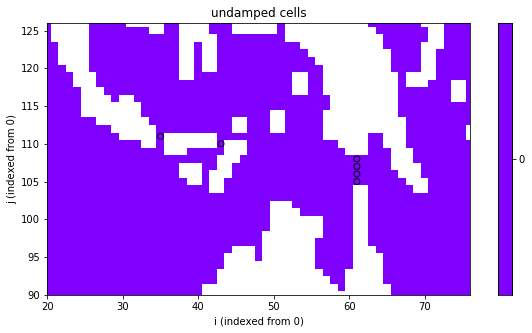

In [5]:
# missing cell plots
margin = 15  # grid cells
maxundamped = int(undamped.max())

if len(damp_time) > 0:
    imin = min(damp_table_ii) - margin
    imax = max(damp_table_ii) + margin
    jmin = min(damp_table_jj) - margin
    jmax = max(damp_table_jj) + margin
    plt.figure(figsize=(10,5))
    plt.imshow(undamped, origin='lower', cmap=plt.get_cmap('rainbow',maxundamped+1))
    plt.colorbar(ticks=range(maxundamped+1))
    plt.clim(-0.5, maxundamped+0.5)
    plt.scatter(damp_table_ii,damp_table_jj, facecolors='none', edgecolors='k')
    plt.xlim(imin,imax)
    plt.ylim(jmin,jmax)
    plt.title('undamped cells')
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
#     savefigure('Rayleigh_undamped_cells')